In [1]:
from pymongo import MongoClient
client = MongoClient()
db = client.whosampled
import numpy as np
import pandas as pd
import re
import implicit
import matplotlib.pyplot as plt
plt.style.use('ggplot')

import random
import scipy.sparse as sparse

import sys
np.set_printoptions(threshold=sys.maxsize)

from src.turn_db_main_into_utility_matrix import from_mongo_collection_to_utility_matrix

In [113]:
prods_in_df = set(db.main_redo.distinct('new_song_producer'))

print("Total: {}".format(len(prods_in_df)))

prods_done = set(db.exhaustive_producers.distinct('dj'))
print("Done: {}".format(len(prods_done)))
      
producers_to_do = prods_in_df.difference(prods_done)
print('To Do: {}'.format(len(producers_to_do)))


Total: 7199
Done: 1539
To Do: 5968


In [115]:
print(len(prods_in_df) - (len(producers_to_do) + len(prods_done)))

-308


In [119]:
#pages we've done
done_URLS = set(db.main_redo.distinct('URL'))
print("# done: {}".format(len(done_URLS)))

#total pages we have links to
song_sample_pages = db.song_sample_pages.find({}, {"link": 1, "_id": 0})
song_sample_pages = set([element['link'] for element in song_sample_pages])

print("total pages we have links to: {}".format(len(song_sample_pages)))

#total pages we've left
song_sampled_pages_to_do = song_sample_pages.difference(done_URLS)

print("Number of pages we've left: {}".format(len(song_sampled_pages_to_do)))


# done: 57000
total pages we have links to: 149447
Number of pages we've left: 92447


In [18]:
df2 = df.drop_duplicates(['URL', 'new_song_producer'])

In [28]:
len(df.URL.unique())

55687

Without outliers removed, the mean and median time of sample appearance is 1:02 and 0:17, respectively.
With outliers removed, the mean and median are 0:56 and 0:16.


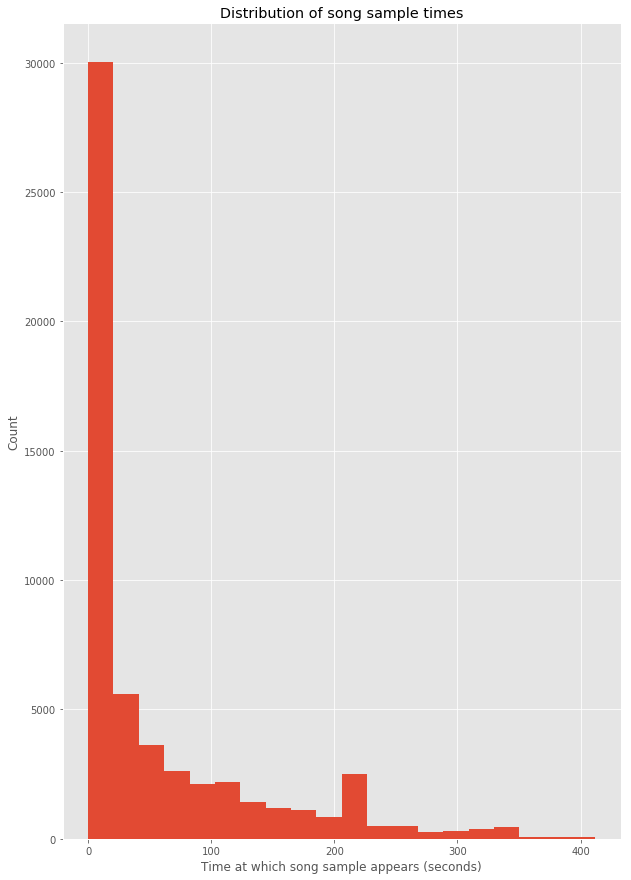

In [523]:
#Plot distribution of song_sample_times

subset = df.sample(n = 50)

# #Filter out "None Listed" in the time column
df = df[df.time_in_sampled_song_where_sample_appears != "None Listed"]

df = df[df.time_in_sampled_song_where_sample_appears.str.contains(":")]

# #Make new column with the number of seconds into a song the sample appears.
df['seconds_into_song'] = \
        df.time_in_sampled_song_where_sample_appears.apply(
        lambda x: x.split(":")).apply(
        lambda x: int(x[0]) * 60 +int(x[1]))

def get_mean_or_median_from_column(column, stat):
    '''
    Get mean in seconds and time format
    Put mean_minutes and seconds together to make time
    ''' 
    #Get mean or median of the column
    agg = int(stat(column))
    
    minutes = str(int(agg / 60))
    seconds = agg % 60    
    if seconds > 9:
        time = minutes + ":" + str(seconds)
    else: 
        time = minutes + ":0" + str(seconds)
    return time

def filter_df_outside_three_sds(column, df):
    
    '''
    Takes a column and calculates mean and std, then removes anything above that outer outlier bound.
    '''
    standard_deviation = column.std()
    outer_outlier_bound = np.mean(column) + 3 * standard_deviation
    filtered_df = df[column < outer_outlier_bound]
    return filtered_df

mean_time = get_mean_or_median_from_column(df.seconds_into_song, np.mean)
median_time = get_mean_or_median_from_column(df.seconds_into_song, np.median)

filtered_df = filter_df_outside_three_sds(df.seconds_into_song, df)

filtered_mean_time = get_mean_or_median_from_column(filtered_df.seconds_into_song, np.mean)
filtered_median_time = get_mean_or_median_from_column(filtered_df.seconds_into_song, np.median)

print(
"Without outliers removed, the mean and median time of sample appearance is {} and {}, respectively.\n\
With outliers removed, the mean and median are {} and {}."
    .format(mean_time, median_time, filtered_mean_time, filtered_median_time))

fig, ax = plt.subplots(figsize = (10, 15))
# ax.boxplot(filtered_subset.seconds_into_song)
ax.set(xlabel = "Time at which song sample appears (seconds)", ylabel = "Count", title = "Distribution of song sample times")
_ = ax.hist(filtered_df.seconds_into_song, bins = 20)

# get max time at which sample was taken
# max_time = np.max(filtered_subset.seconds_into_song)
# minutes = np.arange(0, max_time/60, 1)
# times = [str(minute) + ":00" for minute in minutes]
# import matplotlib.dates as md
# xlocator = md.MinuteLocator(byminute=[0,15,30,45], interval = 1)

# seclocator = md.SecondLocator(bysecond=[20, 40]) 
# minlocator = md.MinuteLocator(byminute=range(60))  # range(60) is the default

# seclocator.MAXTICKS = 40000
# minlocator.MAXTICKS = 40000

# ax.xaxis.set_major_locator(minlocator)
# plt.setp(ax.xaxis.get_majorticklabels(), rotation=90)

# ax.xaxis.set_minor_locator(seclocator)
# plt.setp(ax.xaxis.get_minorticklabels(), rotation=90)

In [435]:

# max_minutes = int(np.floor(/60) ) +1
# seconds = [":00", ":30"] * max_minutes.append
# print(seconds)
# range(0, max_minutes+1)

# labels = ax[1].get_xticklabels()
# print(labels)
# minutes = [int(label) / 60 for label in labels]
# seconds = [int(label) % 60 for label in labels] 
# ax[1].set_xticklabels(subset.time_in_sampled_song_where_sample_appears)


Earliest sampled year in dataset is 1241. Latest is 2018
Year with most samples is 1973, with 3706 samples


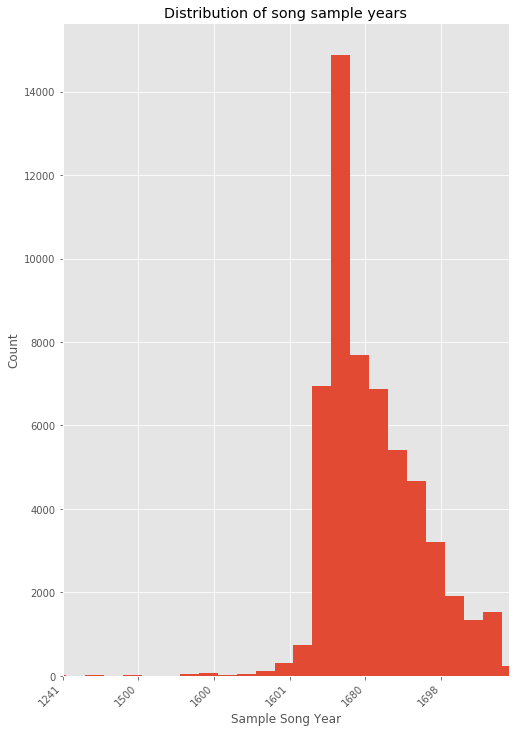

In [540]:
# What year has most sampled artist?
# Or we get the range of years tht had most
subset = df.sample(n = 100)

df = df[df.sampled_song_year != "None Listed"]
df = df[df.sampled_song_year != 0]

min_year = df.sampled_song_year.astype(int).min()
max_year = df.sampled_song_year.astype(int).max()
print("Earliest sampled year in dataset is {}. Latest is {}".format(min_year, max_year))

df = filter_df_outside_three_sds(df.sampled_song_year, df)

sampled_year_counts = df.groupby(df.sampled_song_year).agg(len)['URL']
print("Year with most samples is {}, with {} samples".format(sampled_year_counts.idxmax(), sampled_year_counts.max()))

fig, ax = plt.subplots(figsize = (8, 12))
ax.hist(df.sampled_song_year.astype(int), density = False, bins = range(min_year, max_year +5, 5))
ax.set_xticklabels(sampled_year_counts.index, rotation = 45, ha = 'right')
ax.set_xlim([1900, 2018])
_ = ax.set(xlabel = "Sample Song Year", ylabel = "Count", title = "Distribution of song sample years")


# _ = ax[1].bar(x = sampled_year_counts.index, height = sampled_year_counts.values)

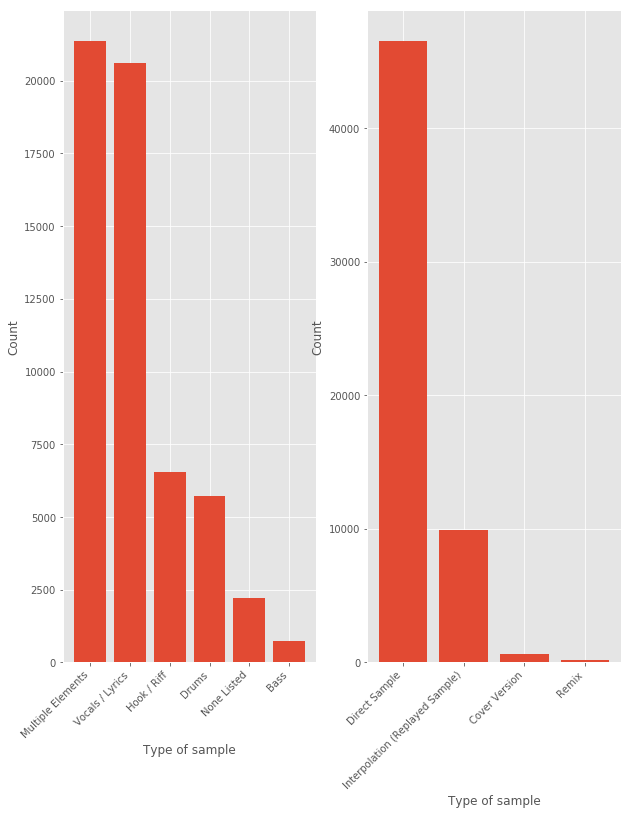

In [545]:
#Are they direct sample or interpolations?
subset = df.sample(n = 100)
df = df[df.sampled_song_year != "None Listed"]

#split into types and elements
df['type_of_sample'] = df.elements_sampled.apply(lambda x: x.split("of")[0].strip() if "of" in x else x)
df['elements_sampled'] = df.elements_sampled.apply(lambda x: x.split("of")[1].strip() if "of" in x else "None Listed")

elements_counts = df.groupby(df.elements_sampled).agg(len)['URL'].sort_values(ascending = False)
type_counts = df.groupby(df.type_of_sample).agg(len)['URL'].sort_values(ascending = False)

fig, ax  = plt.subplots(nrows = 1, ncols =2, figsize = (10,12))

for position, graph in zip([0,1], [elements_counts, type_counts]):
    
    ax[position].set_xticklabels(graph.index, rotation = 45, ha = 'right')
    ax[position].bar(x = graph.index, height = graph.values)
    ax[position].set(xlabel = "Type of sample", ylabel = "Count", label = "Sample Type Distributions")

total pages we have links to: 148530
Number of pages we've left: 92843


In [ ]:
#song_sampled_pages_to_do2 = [song_sample_pages[i] for i in song_sampled_pages_to_do]

In [473]:
len(df.sampled_artist_song.unique())

len(df.new_song_producer.unique())

6460

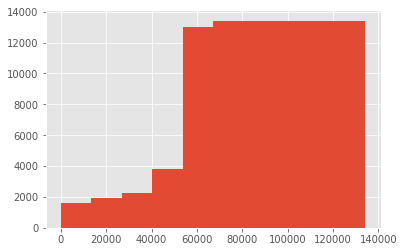

In [457]:
fig, ax = plt.subplots()
_=ax.hist(song_sampled_pages_to_do)

Madlib is the producer with the most samples, with 1598 unique sampling instances.
Beside is the most sampled artist, sampled 1775 times.


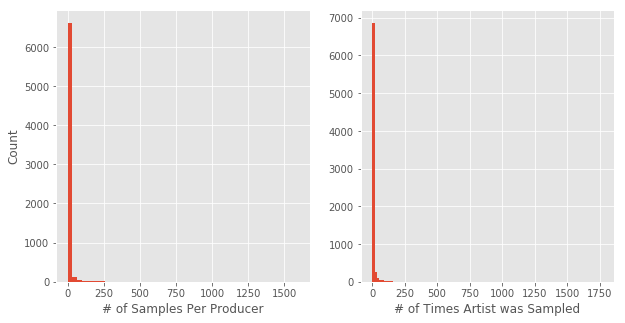

In [546]:
# Plot distributions of numbers of sampled, and max values.

producers = utility_to_artist.sum(axis =0)
sampled_artists = utility_to_artist.sum(axis =1)

prod_with_most_samples = utility_to_artist.sum(axis = 0).idxmax()
most_sampled_artist = utility_to_artist.sum(axis = 1).idxmax()
most_samples = utility_to_artist.sum(axis = 0).max()
times_sampled = utility_to_artist.sum(axis = 1).max()

print(
"{} is the producer with the most samples, with {} unique sampling instances.\n\
{} is the most sampled artist, sampled {} times.".format(
        prod_with_most_samples, most_samples, most_sampled_artist, times_sampled))

fig, ax = plt.subplots(1,2, figsize = (10,5))
ax[0].set(xlabel = "# of Samples Per Producer", ylabel = "Count")
_ = ax[0].hist(producers, bins = 50)

# ax.annotate('local max', xy=(xmax, ymax), xytext=(xmax, ymax+5),
#             arrowprops=dict(facecolor='black', shrink=0.05),
#             )
ax[1].set(xlabel = "# of Times Artist was Sampled")
_ = ax[1].hist(sampled_artists, bins = 100)

In [547]:
# Top ten producers

utility_to_artist.sum(axis = 0).sort_values(ascending =False)\
.to_frame().rename(columns ={0:"Count"}).head(10)

,Count
new_song_producer,
Madlib,1598
J Dilla,1192
9th Wonder,1122
Pete Rock,1009
DJ Premier,985
The Alchemist,954
DJ Paul,931
Juicy J,816
Marley Marl,781


In [548]:
# Top ten most sampled artists

utility_to_artist.sum(axis = 1).sort_values(ascending =False)\
.to_frame().rename(columns ={0:"Count"}).head(10)

#These results are shocking- Three 6 Mafia?

#I checked and they are right- three 6 gets sampled a lot.

,Count
sampled_artist,
Beside,1775
James Brown,1681
Kool & the Gang,1311
"Earth, Wind & Fire",561
Public Enemy,511
"Funk, Inc.",492
Skull Snaps,457
The Notorious B.I.G.,442
Jay-Z,388


In [549]:
# How sparse is matrix?
for ut_mat, label in zip([utility_to_artist, utility_to_song], ["Artist Matrix", "Song Matrix"]):
    matrix_size = ut_mat.shape[0]*ut_mat.shape[1] # Number of possible interactions in the matrix
    nonzeros = sum(ut_mat.sum(axis=0))
    sparsity = 100*(1 - (nonzeros/matrix_size))
    print("{} has {} interactions out of {} possible, resulting in a {} % sparse matrix"
          .format(label, nonzeros, matrix_size, round(sparsity, 3)))

#We have a matrix that is 99.8% sparse. Kind of a problem. According to https://jessesw.com/Rec-System/ 
# maximum is 99.5%

#If we go by artist, we get down to 99.765%

Artist Matrix has 58140 interactions out of 50679990 possible, resulting in a 99.885 % sparse matrix
Song Matrix has 58140 interactions out of 132927630 possible, resulting in a 99.956 % sparse matrix


In [144]:
# May not use this cell.

from src.first_recommender_using_implict import get_model_and_user_items_from_utility_matrix
model, user_items_sparse = get_model_and_user_items_from_utility_matrix(utility_to_artist)

100%|██████████| 100.0/100 [00:06<00:00, 16.60it/s, loss=0.000813]


In [468]:
#What's up with Kanye?
print(utility_to_artist.loc["James Brown","Kanye West"])

#Actually, there is a 3 for Otis Redding- 
#is that because Kanye sampled him three times?

#An 11 for James Brown! Wow.

sum(utility_to_song.loc[:,"Kanye West"])
#Apparently he sampled 640 artists, also 640 songs.

14


750

In [8]:
utility_to_artist.head()

new_song_producer,"""Buttnaked"" Tim Dawg",$uicideboy$,10,12 Finger Dan,12 Million,138th,14Kt,1500 or Nothin',2 in Rhythm,21 Savage,...,Zavala,Zaytoven,Zen Zan,Zero 7,Zukhan Bey,d.r.u.g.s.,hAZEL,i.V.,nineteen85,will.i.am
sampled_artist,,,,,,,,,,,,,,,,,,,,,
"""Sweet"" Charles Sherrell",0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
'Lee' George Quinones,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
*NSYNC,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
.380,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1 Life 2 Live,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [550]:
# Make train set.
# First, we do in the most basic way: Set twenty percent of actual 
#interactions to non-interactions. Don't do it by row, just entire dataframe.

#transpose matrix, because he has users as columns (which certainly makes more sense.)
utility_to_artist_sparse = sparse.csr_matrix(utility_to_artist.T)

from src.make_train_set import make_train

train_set, test_set, user_rows_altered = make_train(utility_to_artist_sparse, 0.01)

In [551]:
#Settings from https://jessesw.com/Rec-System/
# He says these are best
#However the method is deprecated- I can use the recommendations thing instead but no alpha
alpha = 15
user_vecs, item_vecs = implicit.alternating_least_squares((train_set*alpha).astype('double'), 
                                                          factors=20, 
                                                          regularization = 0.1, 
                                                         iterations = 50)

This method is deprecated. Please use the AlternatingLeastSquares class instead
100%|██████████| 50.0/50 [00:12<00:00,  6.20it/s]


In [552]:
from src.auc_testing import auc_score, calc_mean_auc

calc_mean_auc(train_set, user_rows_altered, [sparse.csr_matrix(user_vecs), sparse.csr_matrix(item_vecs.T)], test_set)

(0.758, 0.891)

In [553]:
# Record of scores
train_set = [0.5, 0.3, 0.2, 0.1, 0.05, 0.01, 0.005, .001, 0.0005]
alpha = 15

def test_different_train_test_split(split, alpha):
    
    '''
    This function splits data using make_train, 
    Trains a new model on the data and makes predictions using implicit library.
    Calculates mean_auc of the model as well as the mean_auc of popularity alone. 
    Input: A train_test split, alpha value.
    
    '''
    train_set, test_set, user_rows_altered = make_train(utility_to_artist_sparse, split)
    user_vecs, item_vecs = implicit.alternating_least_squares((train_set*alpha).astype('double'), 
                                                          factors=20, 
                                                          regularization = 0.1, 
                                                         iterations = 50)
    return calc_mean_auc(train_set, user_rows_altered, [sparse.csr_matrix(user_vecs), sparse.csr_matrix(item_vecs.T)], test_set)
    
scores = [test_different_train_test_split(split, alpha) for split in train_set]

100%|██████████| 50.0/50 [00:08<00:00,  5.43it/s]
100%|██████████| 50.0/50 [00:08<00:00,  5.88it/s]
100%|██████████| 50.0/50 [00:08<00:00,  5.83it/s]
100%|██████████| 50.0/50 [00:08<00:00,  5.90it/s]
100%|██████████| 50.0/50 [00:09<00:00,  3.02it/s]
100%|██████████| 50.0/50 [00:09<00:00,  5.21it/s]
100%|██████████| 50.0/50 [00:09<00:00,  5.41it/s]
100%|██████████| 50.0/50 [00:09<00:00,  4.94it/s]
100%|██████████| 50.0/50 [00:08<00:00,  6.01it/s]


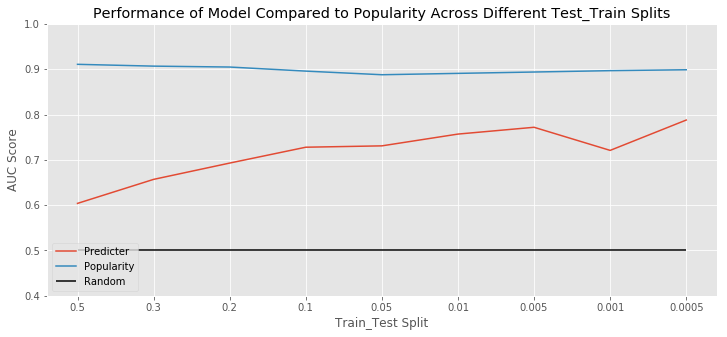

In [554]:
fig, ax = plt.subplots(figsize = (12, 5))
plt.xticks(np.arange(0, 9, 1), train_set)

#Plot Predicter versus Popularity alone. 

for num, label in zip(range(2), ["Predicter", "Popularity"]):
    ax.plot([i[num] for i in scores], label = label)
ax.hlines(0.5, 0, 8, label = "Random")
ax.set(xlabel = "Train_Test Split", 
       ylabel = "AUC Score", 
       title = "Performance of Model Compared to Popularity Across Different Test_Train Splits",
      ylim = (0.4, 1))
_ = ax.legend(loc = 'best')
    